In [1]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
#torch.multiprocessing.set_start_method("spawn")
import cnn
from sklearn.model_selection import KFold

import os
import numpy as np
import pandas as pd
from utils import progress_bar
from skimage import transform as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
test = pd.read_json(BASE_dir + 'test.json')

In [3]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None, test=False): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
        self.test= test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            
            #rotate, scale, shear, translation
#             if self.test is False:
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 scale1 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 scale2 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 #shear = np.random.uniform(-np.pi/18, np.pi/18)
#                 #tran = np.random.uniform(-5, 5)
#                 #aug = tf.AffineTransform(shear = shear, translation=tran, scale= (scale1, scale2))
#                 aug = tf.AffineTransform(scale= (scale1, scale2))
#                 img = tf.warp(img, inverse_map=aug)
            
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
            
#             if self.test is False:
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
#                 #scale = np.exp(np.random.uniform(np.log(1/1.1), np.log(1.1)))
#                 #aug = tf.AffineTransform(scale= (scale, scale))
#                 #img = tf.warp(img, inverse_map=aug)
# #                 angle = np.random.uniform(0,360)
# #                 img = tf.rotate(img,angle=angle,resize=False)
#                 angle = np.random.choice([0, 30,60],size=1)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 rotate = np.random.randint(4, size=1)
#                 if rotate:
#                     img = np.rot90(img,k=rotate,axes=(1,2)).copy()
            pass
        img = torch.from_numpy(img).type(dtype)
        img = self.transform(img)

        return img, label

def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
#     data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

# def data_aug(X, y):    
#     X_rot_30 = []
#     X_rot_60 = [] 
#     X_h = np.flip(X, 3)
#     X_v = np.flip(X, 2)
#     for i in X:
#         X_rot_30.append(tf.rotate(i,angle=30,resize=False))
#         X_rot_60.append(tf.rotate(i,angle=60,resize=False))
        
#     X_rot_30 = np.stack(X_rot_30)
#     X_rot_60 = np.stack(X_rot_60)
#     ch_y = np.concatenate((y,y,y,y,y))
#     ch_X = np.concatenate((X, X_h, X_v, X_rot_30, X_rot_60))
#     return ch_X, ch_y

def data_aug(X, y):    
    X_rot_30 = []
    X_rot_60 = [] 
    X_h = np.flip(X, 3)
    X_v = np.flip(X, 2)
    for i in X:
        X_rot_30.append(tf.rotate(i,angle=90,resize=False))
        X_rot_60.append(tf.rotate(i,angle=270,resize=False))
        
    X_rot_30 = np.stack(X_rot_30)
    X_rot_60 = np.stack(X_rot_60)
    ch_y = np.concatenate((y,y,y,y,y))
    ch_X = np.concatenate((X, X_h, X_v, X_rot_30, X_rot_60))
    return ch_X, ch_y



train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [18]:
#data.inc_angle = data.inc_angle.map(lambda x: 0.0 if x == 'na' else x)
sum(np.where(data.inc_angle > 0)[0])

1470

In [4]:
# train_index=list(range(1300))
# val_index= list(range(1300,1604))
# train_index=list(range(304,1604)) 
# val_index= list(range(304))
# # train_X[train_index].shape

# # seed= np.random.RandomState(123)
# # spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# # train_index, val_index = next(spliter.split(train_X))
# train_mean, train_std = transform_compute(train_X[train_index])
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

## add augmentation 
# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X))

# train_X_af,train_y_af = data_aug(train_X[train_index], train_y[train_index])
# train_mean, train_std = transform_compute(train_X_af)
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(data= train_X_af, label=train_y_af, transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

#data.inc_angle = data.inc_angle.map(lambda x: 0.0 if x == 'na' else x)
train_X_del = train_X[data.inc_angle!='na',:,:,:]
train_y_del = train_y[data.inc_angle!='na']
# # train_X_del = train_X
# # train_y_del = train_y



# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X_del))
# # train_index=list(range(284,1471)) 
# # val_index= list(range(284))

# train_mean, train_std = transform_compute(train_X_del[train_index]))
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])
# af_train_X, af_train_y = data_aug(train_X_del[train_index], train_y_del[train_index])


# train_dataset = iceberg_dataset(data= af_train_X, label=af_train_y, transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X_del[val_index], label=train_y_del[val_index], transform=train_transform, test=True)

# train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)


train_index=list(range(1604)) 
# # seed= np.random.RandomState(123)
# # spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# # train_index, val_index = next(spliter.split(train_X))
train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])


In [23]:
# torch.cuda.is_available()
# torch.from_numpy(train_X).type(torch.FloatTensor)[1].shape
# train_X[1]
# use_cuda
optimizer.param_groups[0]['lr']

0.0005

In [5]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'cnn_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                print('loss: Save it!')
                torch.save(net.state_dict(), 'cnn_loss.pth')
                
        if loss_avg/total < 0.18 and val_loss < 0.18:
            torch.save(net.state_dict(), 'spec_cnn_acc.pth')
#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_acc,i

    return best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

In [24]:
cnn_net = cnn.plain_cnn(num_classes=2)
net= cnn_net

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here   
#(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00175, nesterov= True)
#optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.0001)
#scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience =15,min_lr= 0.0001)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=200,early_stopping= 20)


This is epoch:1
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.646 | Acc: 64.439% (3789/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.599 | Acc: 73.898% (218/295)
acc: Save it!

This is epoch:2
[========= 184/184 ======>]Step: 0ms| Tot: 3s|Loss: 0.497 | Acc: 76.344% (4489/5880)92)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.387 | Acc: 84.407% (249/295)
acc: Save it!

This is epoch:3
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.475 | Acc: 77.704% (4569/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.364 | Acc: 82.712% (244/295)

This is epoch:4
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.453 | Acc: 77.925% (4582/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.386 | Acc: 83.390% (246/295)

This is epoch:5
[========= 184/184 ======>]Step: 0ms| Tot: 2s9ms|Loss: 0.430 | Acc: 79.422% (4670/5880)
[=========   5/  5 ==>....]Step: 0ms| Tot: 0ms|Loss: 0.399 | Acc: 83.390% (246/295)

This is epoch:6
[=========

(93.55932203389831, 81)

In [76]:
##For continue training
resnet34 = resnet.resnet34(num_classes=2)
net= resnet34
net.load_state_dict(torch.load('save_resnet34_acc.pth'))

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00012, nesterov= True)
scheduler = MultiStepLR(optimizer, [50,100], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

#train(epoch=150)


test_set = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test_set)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)
result = []
for i in range(10):
    train(epoch=1)

    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    result.append(np.concatenate(prob))


This is epoch:1
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s272ms | Loss: 0.175 | Acc: 92.538% (1203/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 171ms | Loss: 0.194 | Acc: 93.092% (283/304)
[=================== 132/132 ================>]  Step: 33ms | Tot: 5s848ms

This is epoch:1
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s282ms | Loss: 0.169 | Acc: 92.846% (1207/1300)
[=================== 5/5 ============>........]  Step: 34ms | Tot: 168ms | Loss: 0.195 | Acc: 92.434% (281/304)
[=================== 132/132 ================>]  Step: 32ms | Tot: 5s827ms

This is epoch:1
[=================== 41/41 =================>.]  Step: 65ms | Tot: 3s279ms | Loss: 0.176 | Acc: 92.154% (1198/1300)
[=================== 5/5 ============>........]  Step: 33ms | Tot: 170ms | Loss: 0.194 | Acc: 92.763% (282/304)
[=================== 132/132 ================>]  Step: 33ms | Tot: 5s807ms

This is epoch:1
[=================== 41

In [75]:
test_set = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test_set)
test_X.shape

(8424, 3, 75, 75)

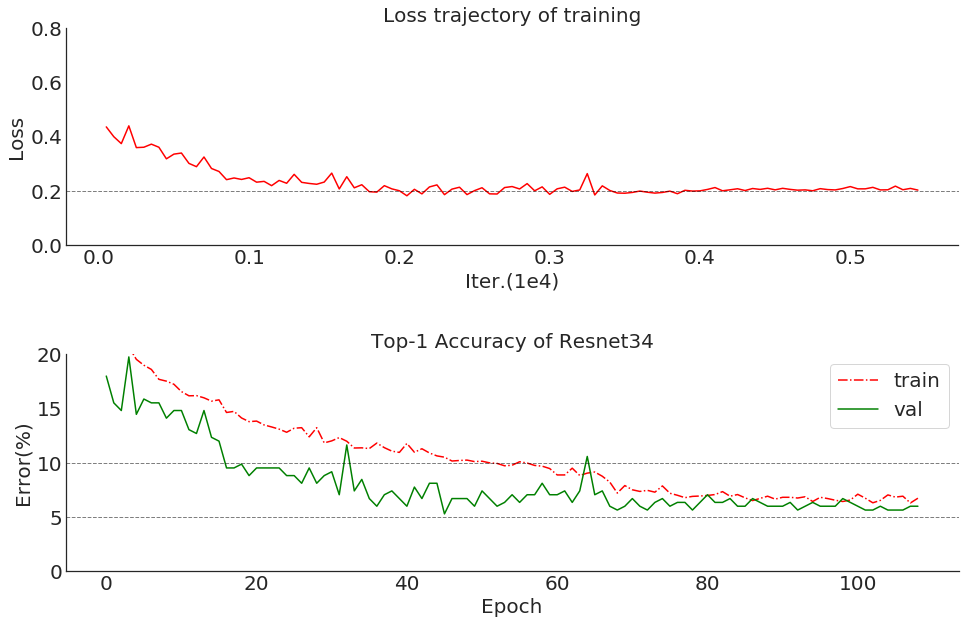

In [27]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.8))
fig1.axhline(y=[0.2],alpha=0.5, linestyle='--',color='k',linewidth=1)

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet34',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

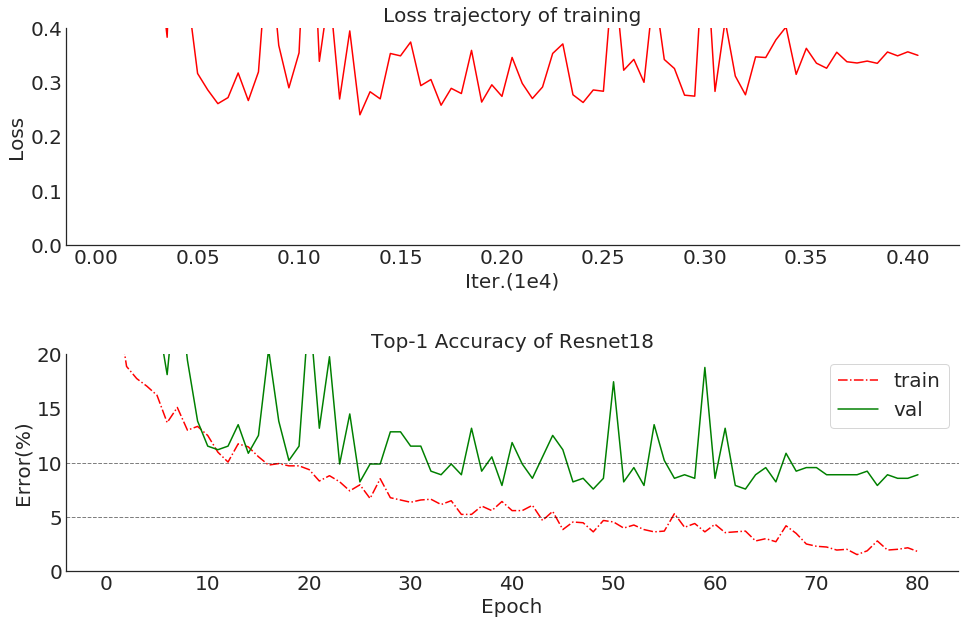

In [12]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.4))

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet18',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

In [18]:
out1 = torch.cat((out.data,out.data),1)
out1.size()
# out
criterion(out,y.long())
type(predicted)
type(y.data)
#predicted.eq(y.data).cpu().sum()

torch.cuda.DoubleTensor

In [ ]:
net = cnn.plain_cnn(num_classes=2)
net.load_state_dict(torch.load('cnn_loss.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))

In [77]:
k =np.stack(result).mean(axis=0)
# #sub.shapesub.to_csv('submission2.csv',index=False)
# result[1].shape
# np.concatenate(prob).shape

In [63]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] =  np.concatenate(prob)
sub.shape
sub.to_csv('submission1111.csv',index=False)

In [41]:
temp= pd.read_csv('submission3.csv') #0.0001 wd one
sub['is_iceberg2'] = temp['is_iceberg']
sub.corr()

,is_iceberg,is_iceberg2
is_iceberg,1.000000,0.886197
is_iceberg2,0.886197,1.000000


In [9]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
        #scheduler.step()
        scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_cuda:
                batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = net(x)
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'cnn_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                print('loss: Save it!')
                torch.save(net.state_dict(), 'cnn_loss.pth')

#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,i

    return best_val_loss, best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x, val_y) in enumerate(val_load):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

#Try different transformation

for rou in range(10):
    ran_num = np.random.randint(10000,size=1)
    seed= np.random.RandomState(ran_num)
    spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
    for k,(train_index, val_index) in enumerate(spliter.split(train_X_del)):
        
        train_mean, train_std = transform_compute(train_X_del[train_index]))
        train_transform = T.Compose([
            T.Normalize(train_mean, train_std)
        ])
        af_train_X, af_train_y = data_aug(train_X_del[train_index], train_y_del[train_index])
        
        train_dataset = iceberg_dataset(data= af_train_X, label=af_train_y, transform=train_transform)
        val_dataset = iceberg_dataset(data= train_X_del[val_index], label=train_y_del[val_index], transform=train_transform, test=True)

        train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                                  shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)
        
        candidate = []
        for rep in range(3):
            cnn_net = cnn.plain_cnn(num_classes=2)
            net= cnn_net

            criterion = nn.CrossEntropyLoss()

            optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00175, nesterov= True)
            scheduler = ReduceLROnPlateau(optimizer, 'max', patience =15,min_lr= 0.0001)
            #5e-3 86
            if use_cuda:
                criterion.cuda()
                net.cuda()

            result = train(epoch=250,early_stopping= 20)
            candidate.append(result[0])
            with open("\log.txt", "a") as myfile:
                msg = 'At fold {}, seed {},round {} we find one with acc: {}, loss: {}\n'.format(
                                                            k,ran_num,rep+1, result[1], result[0])
                myfile.write(msg)
            cmd = 'cp acc_loss.pth acc_loss{}.pth'.format(rep)
            os.system(cmd)    
            if len(candidate)==2:
                if np.sum(np.array(candidate)<0.18)==2:
                    continue
                else:
                    break
        #actually an array
        final_list = np.union1d(np.where(np.array(candidate) <0.18)[0], [candidate.index(max(candidate))])
        

        word= ''
        for i in np.array(candidate)[final_list]:
            word = word +', '+ str(i)
        
        for g in final_list:
            with open("\result.txt", "a") as myfile:
                msg = 'At fold {}, seed {},round {} we find {} with loss: {}\n'.format(
                                                            k,ran_num,rep+1, len(final_list), word)
                myfile.write(msg)
            cmd = 'cp acc_loss{}.pth plain_cnn_models/cnn{}_{}{}.pth'.format(g,rou,k,g)
            os.system(cmd)


This is epoch:1
[=================== 41/41 =================>.]  Step: 184ms | Tot: 15s839ms | Loss: 4.738 | Acc: 52.689% (676/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 806ms | Loss: 21.001 | Acc: 54.206% (174/321)) Step: 200ms | Tot: 390ms | Loss: 27.292 | Acc: 49.479% (95/192)

This is epoch:2
[=================== 41/41 =================>.]  Step: 186ms | Tot: 15s800ms | Loss: 1.305 | Acc: 53.313% (684/1283)
[=================== 6/6 =============>.......]  Step: 17ms | Tot: 800ms | Loss: 3.006 | Acc: 54.829% (176/321))

This is epoch:3
[=================== 41/41 =================>.]  Step: 185ms | Tot: 15s791ms | Loss: 0.891 | Acc: 50.195% (644/1283)
[=================== 6/6 =============>.......]  Step: 16ms | Tot: 804ms | Loss: 2.862 | Acc: 51.090% (164/321))

This is epoch:4
[=================== 41/41 =================>.]  Step: 183ms | Tot: 15s809ms | Loss: 0.747 | Acc: 50.039% (642/1283)
[=================== 6/6 =============>.......]  Step: 15ms 

Process Process-24541:
Process Process-24543:
Process Process-24542:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/uti

KeyboardInterrupt: 

In [7]:
#result_hist

temp11 = pd.DataFrame()

for i in range(5):
    net = resnet.resnet34(num_classes=2)
    net.load_state_dict(torch.load('resnet34_acc%d.pth'%i))
    net.cuda()

    test = pd.read_json(BASE_dir + 'test.json')
    test_X = raw_to_numpy(test)
    test_X.shape 
    fake_label = np.zeros(len(test_X))

    test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

    test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' %i
    temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 162ms | Tot: 27s494ms
[=================== 132/132 ================>]  Step: 160ms | Tot: 27s661ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s644ms
[=================== 132/132 ================>]  Step: 162ms | Tot: 27s598ms
[=================== 132/132 ================>]  Step: 161ms | Tot: 27s668ms


In [20]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = result/5
sub.shape
sub.to_csv('submissionll.csv',index=False)

In [25]:
temp11['is_iceberg_max'] = temp11.iloc[:, 0:6].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, 0:6].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, 0:6].median(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

temp11['is_iceberg_base'] = temp11['is_iceberg5']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:6] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:6] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_base']))


In [7]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11['is_iceberg5']
sub.shape
sub.to_csv('submissionm.csv',index=False)

In [6]:
net = cnn.plain_cnn(num_classes=2)
net.load_state_dict(torch.load('plain_cnn_models/cnn_loss2.pth'))
net.cuda()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

temp11=pd.DataFrame()
prob = [] 
net.eval()
for k, (val_x, val_y) in enumerate(test_loader):
    if use_cuda:
        val_x, val_y = val_x.cuda(), val_y.cuda()
    x = Variable(val_x)
    y = Variable(val_y)
    out = net(x)
    #prevent overflow
    temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
    ans= temp[:,1]/(temp.sum(axis=1))
    prob.append(ans)
    #print(out.size())
    progress_bar(k, len(test_loader))
msg = 'is_iceberg%d' %5
temp11[msg]= np.concatenate(prob)

[========= 132/132 ======>]Step: 0ms| Tot: 1s2ms


In [ ]:
temp11.iloc[:,0:5]

In [27]:
temp11.corr()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3,is_iceberg4,is_iceberg5,is_iceberg_max,is_iceberg_min,is_iceberg_median,is_iceberg_base,is_iceberg
is_iceberg0,1.000000,0.852644,0.822586,0.648968,0.883101,0.905277,0.682861,0.922862,0.942663,0.905277,0.905900
is_iceberg1,0.852644,1.000000,0.905401,0.754710,0.833295,0.815734,0.821258,0.777728,0.956190,0.815734,0.816630
is_iceberg2,0.822586,0.905401,1.000000,0.771766,0.774018,0.784324,0.847868,0.738630,0.918857,0.784324,0.785453
is_iceberg3,0.648968,0.754710,0.771766,1.000000,0.685649,0.556919,0.940914,0.592617,0.749656,0.556919,0.559032
is_iceberg4,0.883101,0.833295,0.774018,0.685649,1.000000,0.826391,0.685683,0.920097,0.909537,0.826391,0.827514
is_iceberg5,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683
is_iceberg_max,0.682861,0.821258,0.847868,0.940914,0.685683,0.653849,1.000000,0.583326,0.792055,0.653849,0.655435
is_iceberg_min,0.922862,0.777728,0.738630,0.592617,0.920097,0.895245,0.583326,1.000000,0.875356,0.895245,0.895989
is_iceberg_median,0.942663,0.956190,0.918857,0.749656,0.909537,0.896220,0.792055,0.875356,1.000000,0.896220,0.897011
is_iceberg_base,0.905277,0.815734,0.784324,0.556919,0.826391,1.000000,0.653849,0.895245,0.896220,1.000000,0.999683


In [11]:
seed= np.random.RandomState(67)
spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
for i in spliter.split(list(range(100))):
    print(i)
    break

(array([ 1,  2,  5,  6,  7,  8,  9, 10, 12, 13, 15, 16, 18, 19, 20, 21, 22,
       23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42,
       44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62,
       63, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 99]), array([ 0,  3,  4, 11, 14, 17, 24, 29, 40, 43, 48, 59, 64, 66, 70, 79, 82,
       83, 93, 97]))


In [19]:
temp11 = pd.DataFrame()

test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))

test_dataset = iceberg_dataset(data= test_X, label=fake_label, transform=train_transform,test=True)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)


for i,pth in enumerate([os.path.join('resnet34_save_model',i) for i in os.listdir(path='resnet34_save_model') if '.pth' in i]):
    net = resnet.resnet34(num_classes=2)
    net.load_state_dict(torch.load(pth))
    net.cuda()
    prob = [] 
    net.eval()
    for k, (val_x, val_y) in enumerate(test_loader):
        if use_cuda:
            val_x, val_y = val_x.cuda(), val_y.cuda()
        x = Variable(val_x)
        y = Variable(val_y)
        out = net(x)
        #prevent overflow
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        #print(out.size())
        progress_bar(k, len(test_loader))
    msg = 'is_iceberg%d' % i
    temp11[msg]= np.concatenate(prob)

[=================== 132/132 ================>]  Step: 155ms | Tot: 26s222ms Step: 200ms | Tot: 2s492ms  Step: 199ms | Tot: 2s692ms  Step: 200ms | Tot: 7s692ms  Step: 199ms | Tot: 13s642ms  Step: 200ms | Tot: 14s841ms  Step: 200ms | Tot: 24s62ms
[=================== 132/132 ================>]  Step: 152ms | Tot: 26s199ms Step: 199ms | Tot: 1s425ms  Step: 200ms | Tot: 1s626ms  Step: 200ms | Tot: 8s236ms  Step: 200ms | Tot: 12s639ms  Step: 200ms | Tot: 14s844ms  Step: 199ms | Tot: 16s449ms  Step: 199ms | Tot: 17s647ms  Step: 199ms | Tot: 20s857ms  Step: 200ms | Tot: 23s61ms  Step: 199ms | Tot: 25s648ms  Step: 201ms | Tot: 25s850ms
[=================== 132/132 ================>]  Step: 151ms | Tot: 26s141ms Step: 199ms | Tot: 6s583ms  Step: 199ms | Tot: 6s982ms 41/132   Step: 200ms | Tot: 9s576ms  Step: 200ms | Tot: 11s185ms
[=================== 132/132 ================>]  Step: 155ms | Tot: 26s219ms Step: 200ms | Tot: 3s394ms  Step: 200ms | Tot: 4s393ms 52/132   Step: 200ms | Tot: 10s614

In [26]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] = temp11['is_iceberg']
sub.shape
sub.to_csv('submission2.csv',index=False)

In [24]:
result = temp11.mean(1)
temp11.head()

,is_iceberg0,is_iceberg1,is_iceberg2,is_iceberg3
0,7.027504e-03,9.244031e-02,1.784263e-02,5.578169e-03
1,3.931345e-03,3.659658e-01,2.564293e-01,1.571568e-02
2,5.239599e-10,1.970750e-21,3.803356e-08,2.089403e-21
3,9.993261e-01,9.456407e-01,9.853242e-01,9.989353e-01
4,1.448082e-03,6.435396e-02,3.096765e-02,2.362306e-04


In [25]:
temp11['is_iceberg_max'] = temp11.iloc[:, :4].max(axis=1)
temp11['is_iceberg_min'] = temp11.iloc[:, :4].min(axis=1)
temp11['is_iceberg_median'] = temp11.iloc[:, :4].median(axis=1)
# set up cutoff threshold for lower and upper bounds, easy to twist 
cutoff_lo = 0.8
cutoff_hi = 0.2

temp11['is_iceberg_base'] = temp11['is_iceberg3']
temp11['is_iceberg'] = np.where(np.all(temp11.iloc[:,0:6] > cutoff_lo, axis=1), 
                                    temp11['is_iceberg_max'], 
                                    np.where(np.all(temp11.iloc[:,0:6] < cutoff_hi, axis=1),
                                             temp11['is_iceberg_min'], 
                                             temp11['is_iceberg_base']))

['resnet34_save_model/resnet34_acc01.pth',
 'resnet34_save_model/resnet34_acc33.pth',
 'resnet34_save_model/resnet34_acc03.pth',
 'resnet34_save_model/resnet34_acc24.pth']